# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import tensor
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import pandas as pd
import pydicom as dicom
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from PIL import Image
from skimage import exposure

from glob import glob
import os


Bad key "text.kerning_factor" on line 4 in
C:\Users\lasse\.conda\envs\pytorch\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
if torch.cuda.is_available():
    # you can continue going on here, like cuda:1 cuda:2....etc.
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
DATA_DIR = os.path.join(".", "rsa-pneumonia-data")

TRAIN_IMAGES = os.path.join(DATA_DIR, "stage_2_train_images")
TEST_IMAGES = os.path.join(DATA_DIR, "stage_2_test_images")
PRED_MASK_DIR = os.path.join(DATA_DIR, "stage_2_mask_images")

TRAIN_ANNOTATIONS_FILE = "stage_2_train_labels.csv"
TRAIN_CLASS_FILE = "stage_2_detailed_class_info.csv"

# Dataset Definition
## Opacity Dataset

In [4]:
class OpacityDataset(Dataset):

    def __init__(self, csv_file, root_dir, image_dir, subsample, transform=None):
        self.classes_df = pd.read_csv(csv_file)
        if subsample is not None:
            self.classes_df = self.classes_df[:subsample]
        self.root_dir = root_dir
        self.image_dir = image_dir
        self.transform = transform

        # Convert our classes to integers!
        self.class_dict = {
            "Normal": 0,
            "No Lung Opacity / Not Normal": 0,
            "Lung Opacity": 1
        }

    def __len__(self):
        return len(self.classes_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        # Get the image, preprocess it for our model
        image_path = os.path.join(
            self.image_dir, self.classes_df.iloc[index, 0])
        image = dicom.read_file(image_path + ".dcm").pixel_array
        image = image[::2, ::2]
#         image = image/image.max()
        
#         imshow(image)
#         image = (255*image).clip(0, 255).astype(np.uint8)
        
#         print(image)
#         imshow(image)

        image = Image.fromarray(image).convert("RGB")
        
#         print(image)
#         imshow(image)
        
        opacity_class = self.classes_df.at[index, 'class']
        

        if self.transform:
            image = self.transform(image)
            
        sample = {"image": image,
                  "opacity_class": self.class_dict[opacity_class],
                  "class": opacity_class}

        return sample

## Opacity Mask Dataset

In [5]:
class OpacityMaskDataset(Dataset):

    def __init__(self, csv_file, root_dir, image_dir, subsample, transform=None):
        self.classes_df = pd.read_csv(csv_file)
        if subsample is not None:
            self.classes_df = self.classes_df[:subsample]
        self.root_dir = root_dir
        self.image_dir = image_dir
        self.transform = transform

        # Convert our classes to integers!
        self.class_dict = {
            "Normal": 0,
            "No Lung Opacity / Not Normal": 0,
            "Lung Opacity": 1
        }

    def __len__(self):
        return len(self.classes_df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        # Get the image, preprocess it for our model
#         image_path = os.path.join(
#             self.image_dir, self.classes_df.iloc[index, 0])
#         image = dicom.read_file(image_path + ".dcm").pixel_array
#         image = image[::4, ::4]
#         image = image/image.max()
#         image = (255*image).clip(0, 255).astype(np.uint8)
#         image = Image.fromarray(image).convert("RGB")
        image = Image.open(os.path.join(self.image_dir, self.classes_df.iloc[index, 0] + ".jpeg"))
        opacity_class = self.classes_df.at[index, 'class']

        if self.transform:
            image = self.transform(image)
        
        sample = {"image": image,
                  "opacity_class": self.class_dict[opacity_class],
                  "class": opacity_class}

        return sample

## Definition

In [26]:
validation_split = 0.2;

opacity_dataset = OpacityDataset(
    csv_file=os.path.join(DATA_DIR, TRAIN_CLASS_FILE),
    root_dir=DATA_DIR,
    image_dir=TRAIN_IMAGES,
#     subsample=10000,
    subsample=None,
    transform=transforms.Compose([
        transforms.Grayscale(3),
#         transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
#         transforms.RandomAffine(20),
        transforms.ToTensor()
    ])
)

opacity_dataset[0]

dataset_size = len(opacity_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.seed(1)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Create samplers for data loading
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Hyper Parameters

In [27]:
# Define our NN
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, (3, 3))
#         self.pool = nn.MaxPool2d((2, 2), 2)
#         self.conv2 = nn.Conv2d(16, 32, (3, 3))
#         self.conv3 = nn.Conv2d(32, 64, (3, 3))
#         self.conv4 = nn.Conv2d(64, 128, (3, 3))
#         self.linear1 = nn.Linear(25088, 4086)
#         self.linear3 = nn.Linear(4086, 2)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = x.view(x.size()[0], -1)
#         x = F.relu(self.linear1(x))
#         x = self.linear3(x)
#         return x
    
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=2):
#         super(AlexNet, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(64, 192, kernel_size=5, padding=2),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.Conv2d(192, 384, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(384, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2),
#         )
#         self.classifier = nn.Sequential(
#             nn.Dropout(),
#             nn.Linear(256 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Linear(4096, num_classes),
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), 256 * 7 * 7)
#         x = self.classifier(x)
#         return x

# model = AlexNet()
# model.to(device)

In [7]:
del model
torch.cuda.ipc_collect()
torch.cuda.empty_cache()

In [28]:
# Hyperparameters
epochs = 20
num_classes = 2
batch_size = 12
learning_rate = .001

# Declare Model

In [44]:
model = torchvision.models.resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
feature_num = model.fc.in_features
model.fc = nn.Linear(feature_num, num_classes)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
# model = torchvision.models.vgg11(pretrained=False)
# model.fc = nn.Linear(4096, num_classes)
# model.to(device)

In [31]:
# model = torchvision.models.alexnet(pretrained=False)
# model.fc = nn.Linear(4096, num_classes)
# model.to(device)

## Dataloaders

In [45]:
train_loader = torch.utils.data.DataLoader(
    opacity_dataset, 
    batch_size=batch_size, 
    sampler=train_sampler,
    num_workers=0
)
validation_loader = torch.utils.data.DataLoader(
    opacity_dataset, 
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=0
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Helper Functions
## Tensor Functions

In [46]:
def get_num_from_tensor(tensorItem):
    return tensorItem.cuda().cpu().numpy().item()

def get_numpy_from_tensor(tensorItem):
    return tensorItem.cuda().cpu().numpy()

## Accuracy Functions

In [47]:
def correct_pred_sum(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()
    return correct_pred.sum()

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = acc * 100

    return get_num_from_tensor(acc)

# Model Training

In [48]:
losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    running_train_acc = 0.0
    running_val_acc = 0.0
    running_loss_full = 0.0
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data["image"], data["opacity_class"]
        inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches          
            train_acc = multi_acc(outputs, labels)
            print("[%d, %5d] loss: %.3f training_accuracy: %.2f" % (epoch + 1, i + 1, running_loss / 50, train_acc))
            running_loss = 0.0
       
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data["image"], data["opacity_class"]
        inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_full += loss.item()
        running_train_acc += multi_acc(outputs, labels)
        
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data["image"], data["opacity_class"]
        inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
        outputs = model(inputs)
        running_val_acc += multi_acc(outputs, labels)
        
    curr_train_loss = running_loss_full / len(train_loader)    
    train_acc = running_train_acc / len(train_loader)
    val_acc = running_val_acc / len(validation_loader)
    
    losses.append(curr_train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
        
    print("Epoch [%d] Loss: %.3f Training Accuracy: %.3f Validation Accuracy: %.3f " % (epoch + 1, curr_train_loss, train_acc, val_acc))            
    print("------------------------------------------------------------------------")
print('Finished Training')

[1,    50] loss: 0.638 training_accuracy: 66.67
[1,   100] loss: 0.551 training_accuracy: 75.00
[1,   150] loss: 0.534 training_accuracy: 66.67
[1,   200] loss: 0.549 training_accuracy: 83.33
[1,   250] loss: 0.502 training_accuracy: 66.67
[1,   300] loss: 0.559 training_accuracy: 83.33
[1,   350] loss: 0.527 training_accuracy: 83.33
[1,   400] loss: 0.538 training_accuracy: 75.00
[1,   450] loss: 0.502 training_accuracy: 91.67
[1,   500] loss: 0.497 training_accuracy: 75.00
[1,   550] loss: 0.564 training_accuracy: 75.00
[1,   600] loss: 0.474 training_accuracy: 66.67
[1,   650] loss: 0.505 training_accuracy: 66.67
[1,   700] loss: 0.475 training_accuracy: 83.33
[1,   750] loss: 0.526 training_accuracy: 66.67
[1,   800] loss: 0.483 training_accuracy: 91.67
[1,   850] loss: 0.476 training_accuracy: 75.00
[1,   900] loss: 0.450 training_accuracy: 75.00
[1,   950] loss: 0.480 training_accuracy: 75.00
[1,  1000] loss: 0.453 training_accuracy: 50.00
[1,  1050] loss: 0.530 training_accuracy

[5,    50] loss: 0.413 training_accuracy: 91.67
[5,   100] loss: 0.426 training_accuracy: 75.00
[5,   150] loss: 0.420 training_accuracy: 100.00
[5,   200] loss: 0.423 training_accuracy: 83.33
[5,   250] loss: 0.430 training_accuracy: 75.00
[5,   300] loss: 0.451 training_accuracy: 91.67
[5,   350] loss: 0.405 training_accuracy: 75.00
[5,   400] loss: 0.436 training_accuracy: 83.33
[5,   450] loss: 0.399 training_accuracy: 75.00
[5,   500] loss: 0.402 training_accuracy: 83.33
[5,   550] loss: 0.409 training_accuracy: 83.33
[5,   600] loss: 0.433 training_accuracy: 91.67
[5,   650] loss: 0.422 training_accuracy: 91.67
[5,   700] loss: 0.400 training_accuracy: 83.33
[5,   750] loss: 0.384 training_accuracy: 91.67
[5,   800] loss: 0.429 training_accuracy: 91.67
[5,   850] loss: 0.398 training_accuracy: 91.67
[5,   900] loss: 0.402 training_accuracy: 83.33
[5,   950] loss: 0.456 training_accuracy: 75.00
[5,  1000] loss: 0.455 training_accuracy: 83.33
[5,  1050] loss: 0.428 training_accurac

[9,    50] loss: 0.411 training_accuracy: 91.67
[9,   100] loss: 0.379 training_accuracy: 66.67
[9,   150] loss: 0.396 training_accuracy: 91.67
[9,   200] loss: 0.398 training_accuracy: 83.33
[9,   250] loss: 0.437 training_accuracy: 75.00
[9,   300] loss: 0.403 training_accuracy: 83.33
[9,   350] loss: 0.400 training_accuracy: 91.67
[9,   400] loss: 0.427 training_accuracy: 75.00
[9,   450] loss: 0.374 training_accuracy: 91.67
[9,   500] loss: 0.360 training_accuracy: 75.00
[9,   550] loss: 0.401 training_accuracy: 83.33
[9,   600] loss: 0.416 training_accuracy: 75.00
[9,   650] loss: 0.406 training_accuracy: 75.00
[9,   700] loss: 0.377 training_accuracy: 83.33
[9,   750] loss: 0.402 training_accuracy: 83.33
[9,   800] loss: 0.400 training_accuracy: 66.67
[9,   850] loss: 0.420 training_accuracy: 91.67
[9,   900] loss: 0.401 training_accuracy: 83.33
[9,   950] loss: 0.408 training_accuracy: 91.67
[9,  1000] loss: 0.387 training_accuracy: 75.00
[9,  1050] loss: 0.409 training_accuracy

[12,  2000] loss: 0.380 training_accuracy: 75.00
Epoch [12] Loss: 0.380 Training Accuracy: 82.833 Validation Accuracy: 83.091 
------------------------------------------------------------------------
[13,    50] loss: 0.378 training_accuracy: 91.67
[13,   100] loss: 0.345 training_accuracy: 75.00
[13,   150] loss: 0.393 training_accuracy: 91.67
[13,   200] loss: 0.306 training_accuracy: 83.33
[13,   250] loss: 0.402 training_accuracy: 75.00
[13,   300] loss: 0.364 training_accuracy: 75.00
[13,   350] loss: 0.348 training_accuracy: 91.67
[13,   400] loss: 0.406 training_accuracy: 83.33
[13,   450] loss: 0.385 training_accuracy: 75.00
[13,   500] loss: 0.397 training_accuracy: 75.00
[13,   550] loss: 0.400 training_accuracy: 66.67
[13,   600] loss: 0.392 training_accuracy: 75.00
[13,   650] loss: 0.369 training_accuracy: 100.00
[13,   700] loss: 0.420 training_accuracy: 83.33
[13,   750] loss: 0.419 training_accuracy: 75.00
[13,   800] loss: 0.367 training_accuracy: 66.67
[13,   850] los

[16,  1750] loss: 0.314 training_accuracy: 100.00
[16,  1800] loss: 0.367 training_accuracy: 75.00
[16,  1850] loss: 0.381 training_accuracy: 83.33
[16,  1900] loss: 0.364 training_accuracy: 83.33
[16,  1950] loss: 0.333 training_accuracy: 91.67
[16,  2000] loss: 0.389 training_accuracy: 100.00
Epoch [16] Loss: 0.370 Training Accuracy: 83.164 Validation Accuracy: 83.444 
------------------------------------------------------------------------
[17,    50] loss: 0.349 training_accuracy: 91.67
[17,   100] loss: 0.381 training_accuracy: 66.67
[17,   150] loss: 0.391 training_accuracy: 75.00
[17,   200] loss: 0.354 training_accuracy: 83.33
[17,   250] loss: 0.397 training_accuracy: 83.33
[17,   300] loss: 0.381 training_accuracy: 83.33
[17,   350] loss: 0.357 training_accuracy: 83.33
[17,   400] loss: 0.379 training_accuracy: 91.67
[17,   450] loss: 0.369 training_accuracy: 83.33
[17,   500] loss: 0.411 training_accuracy: 75.00
[17,   550] loss: 0.393 training_accuracy: 83.33
[17,   600] lo

[20,  1500] loss: 0.401 training_accuracy: 91.67
[20,  1550] loss: 0.386 training_accuracy: 75.00
[20,  1600] loss: 0.371 training_accuracy: 91.67
[20,  1650] loss: 0.386 training_accuracy: 66.67
[20,  1700] loss: 0.358 training_accuracy: 75.00
[20,  1750] loss: 0.363 training_accuracy: 91.67
[20,  1800] loss: 0.426 training_accuracy: 75.00
[20,  1850] loss: 0.364 training_accuracy: 91.67
[20,  1900] loss: 0.362 training_accuracy: 75.00
[20,  1950] loss: 0.363 training_accuracy: 75.00
[20,  2000] loss: 0.371 training_accuracy: 91.67
Epoch [20] Loss: 0.368 Training Accuracy: 83.189 Validation Accuracy: 83.344 
------------------------------------------------------------------------
Finished Training


In [49]:
df = pd.DataFrame(zip(losses, train_accuracies, val_accuracies), columns=["Loss", "Train Acc", "Val Acc"])
df.to_csv("resnet-dataloader-fix-affine-rotate-all-data-pretrained.csv")

In [50]:
torch.save(model.state_dict(), 'resnet-dataloader-fix-affine-rotate-all-data-pretrained.pth')

## Plot Val/Train/Loss

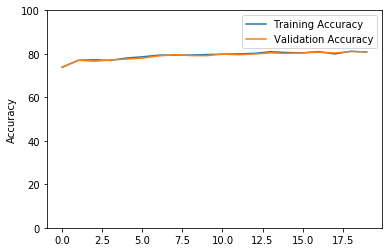

In [38]:
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
# plt.plot(losses, label="Loss")
plt.ylabel("Accuracy")
plt.ylim(0,100)
plt.legend()
plt.show()

## Save Model

In [57]:
model.load_state_dict(torch.load("resnet-dataloader-fix-affine-rotate-all-data-pretrained.pth"))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Data Analysis

In [60]:
results = {
    "pred 0,label 0": 0,
    "pred 0,label 1": 0,
    "pred 1,label 0": 0,
    "pred 1,label 1": 0
}

results_classes = {
    "pred 0,label 0": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    },
    "pred 0,label 1": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    },
    "pred 1,label 0": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    },
    "pred 1,label 1": {
        "Lung Opacity": 0,
        "Normal": 0,
        "No Lung Opacity / Not Normal": 0
    }
}

for i, data in enumerate(validation_loader, 0):
    inputs, labels, classes = data["image"], data["opacity_class"], data["class"]
    inputs, labels = Variable(inputs.cuda(), requires_grad=True), Variable(labels.cuda())
    outputs = model(inputs)
    
    y_pred_softmax = torch.log_softmax(outputs, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)

    correct_pred = (y_pred_tags == labels).float()
    
    for j in range(batch_size):
        try:
            pattern = "pred %d,label %d" % (get_num_from_tensor(y_pred_tags[j]), get_num_from_tensor(labels[j]))
            results[pattern] += 1
            results_classes[pattern][classes[j]] += 1
        except Exception as e:
            print("invalid dimension")
print()
            
for key, value in results.items():
    print(key, value)
    
print()
    
for key, value in results_classes.items():
    print(key, value)

invalid dimension
invalid dimension
invalid dimension

pred 0,label 0 3754
pred 0,label 1 618
pred 1,label 0 387
pred 1,label 1 1286

pred 0,label 0 {'Lung Opacity': 0, 'Normal': 1776, 'No Lung Opacity / Not Normal': 1978}
pred 0,label 1 {'Lung Opacity': 618, 'Normal': 0, 'No Lung Opacity / Not Normal': 0}
pred 1,label 0 {'Lung Opacity': 0, 'Normal': 4, 'No Lung Opacity / Not Normal': 383}
pred 1,label 1 {'Lung Opacity': 1286, 'Normal': 0, 'No Lung Opacity / Not Normal': 0}


## Visualizations 

In [61]:
def custom_imshow(img, title):
    """Custom function to display the image using matplotlib"""

    # define std correction to be made
    std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)

    # define mean correction to be made
    mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)

    # convert the tensor img to numpy img and de normalize
    npimg = np.multiply(img.numpy(), std_correction) + mean_correction

    # plot the numpy image
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


def plot_filters_multi_channel(t):

    # get the number of kernals
    num_kernels = t.shape[0]

    # define number of columns for subplots
    num_cols = 12
    # rows = num of kernels
    num_rows = num_kernels

    # set the figure size
    fig = plt.figure(figsize=(num_cols, num_rows))

    # looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows, num_cols, i+1)

        # for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        # standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.savefig('myimage.png', dpi=100)
    plt.tight_layout()
    plt.show()


def plot_weights(model, layer_num, model_type, single_channel=True, collated=False):

    # extracting the model features at the particular layer number
    if model_type == "resnet":
        layer = list(model.children())[layer_num]
    else:
        layer = model.features[layer_num]
        
    # checking whether the layer is convolution layer or not
    if isinstance(layer, nn.Conv2d):
        # getting the weight tensor data
        if model_type == "resnet":
            weight_tensor = list(model.children())[layer_num].weight.data
        else:
            weight_tensor = model.features[layer_num].weight.data
            
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor)
            else:
                plot_filters_single_channel(weight_tensor)

        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor.cpu())
            else:
                print("Can only plot weights with three channels with single channel = False")

    else:
        print("Can only visualize layers which are convolutional")

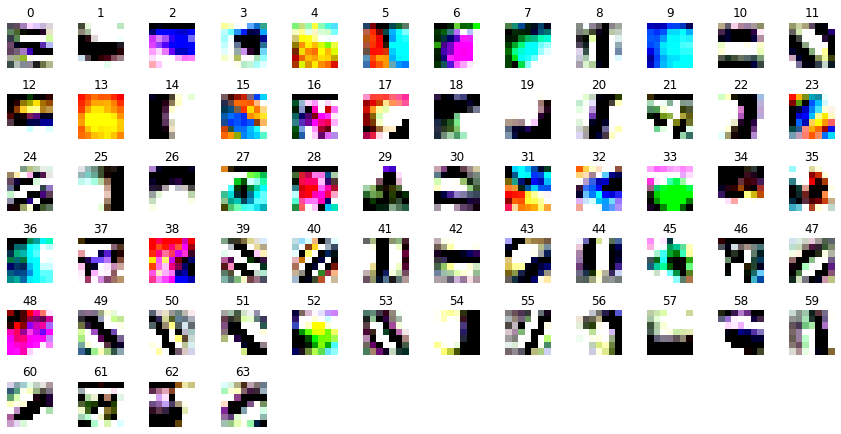

In [62]:
plot_weights(model, 0, "resnet", single_channel = False)